### Install dependencies

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import scipy.stats as stats

2025-05-24 19:27:39.776730: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load dataset

In [2]:
# Load raw data
df = pd.read_csv("../data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

pd.set_option("display.max_columns", None)
# df.head()

### Clean dataset

In [3]:
# Check for missing data
# df.isna().sum()

In [4]:
# Convert 'TotalCharges' to float
df['TotalCharges'] = df['TotalCharges'].apply(lambda x: 0.0 if x == ' ' else float(x))

##

### Explore relationship with target (review based on data groups)

In [5]:
# Chi-square Test
binary_list = ['gender', 'SeniorCitizen', 'Partner', 
               'Dependents', 'PhoneService', 'PaperlessBilling',]

# Crosstab
label_encode_list = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                      'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                      'Contract', 'PaymentMethod',]

# T-test Statistic
ttest_list = ['tenure', 'MonthlyCharges', 'TotalCharges'] 

### Run chi-square on binary list

In [6]:
# --- 1. Chi-square test for binary features ---
print("Chi-square test results (binary features):")
for col in binary_list:
    contingency = pd.crosstab(df[col], df['Churn'])
    chi2, p, dof, expected = stats.chi2_contingency(contingency)
    print(f"{col}: chi2={chi2:.2f}, p-value={p:.4f}")
print("# End of chi-square tests for binary features\n")

Chi-square test results (binary features):
gender: chi2=0.48, p-value=0.4866
SeniorCitizen: chi2=159.43, p-value=0.0000
Partner: chi2=158.73, p-value=0.0000
Dependents: chi2=189.13, p-value=0.0000
PhoneService: chi2=0.92, p-value=0.3388
PaperlessBilling: chi2=258.28, p-value=0.0000
# End of chi-square tests for binary features



### Crosstab and run chi-square test on label encode list

In [7]:
from sklearn.preprocessing import LabelEncoder

def apply_label_encoding(df, list_features):
    le = LabelEncoder()

    for feature in list_features:
        df[f'{feature}_encoded'] = le.fit_transform(df[feature])
    
    return df

df = apply_label_encoding(df, label_encode_list)

In [8]:
# --- 2. Crosstab (chi-square) for label-encoded categorical features ---
print("Chi-square test results (label-encoded features):")
for col in label_encode_list:
    encoded_col = f"{col}_encoded"
    if encoded_col in df.columns:
        contingency = pd.crosstab(df[encoded_col], df['Churn'])
        chi2, p, dof, expected = stats.chi2_contingency(contingency)
        print(f"{encoded_col}: chi2={chi2:.2f}, p-value={p:.4f}")
print("# End of chi-square tests for label-encoded features\n")

Chi-square test results (label-encoded features):
MultipleLines_encoded: chi2=11.33, p-value=0.0035
InternetService_encoded: chi2=732.31, p-value=0.0000
OnlineSecurity_encoded: chi2=850.00, p-value=0.0000
OnlineBackup_encoded: chi2=601.81, p-value=0.0000
DeviceProtection_encoded: chi2=558.42, p-value=0.0000
TechSupport_encoded: chi2=828.20, p-value=0.0000
StreamingTV_encoded: chi2=374.20, p-value=0.0000
StreamingMovies_encoded: chi2=375.66, p-value=0.0000
Contract_encoded: chi2=1184.60, p-value=0.0000
PaymentMethod_encoded: chi2=648.14, p-value=0.0000
# End of chi-square tests for label-encoded features



### Run T-test on numeric list

In [9]:
# --- 3. T-test for numeric features ---
print("T-test results (numeric features):")
for col in ttest_list:
    group0 = df[df['Churn'] == 'No'][col]
    group1 = df[df['Churn'] == 'Yes'][col]
    t_stat, p = stats.ttest_ind(group0, group1, nan_policy='omit')
    print(f"{col}: t-stat={t_stat:.2f}, p-value={p:.4f}")
print("# End of t-tests for numeric features")

T-test results (numeric features):
tenure: t-stat=31.58, p-value=0.0000
MonthlyCharges: t-stat=-16.54, p-value=0.0000
TotalCharges: t-stat=16.98, p-value=0.0000
# End of t-tests for numeric features


### View distribution of numeric features

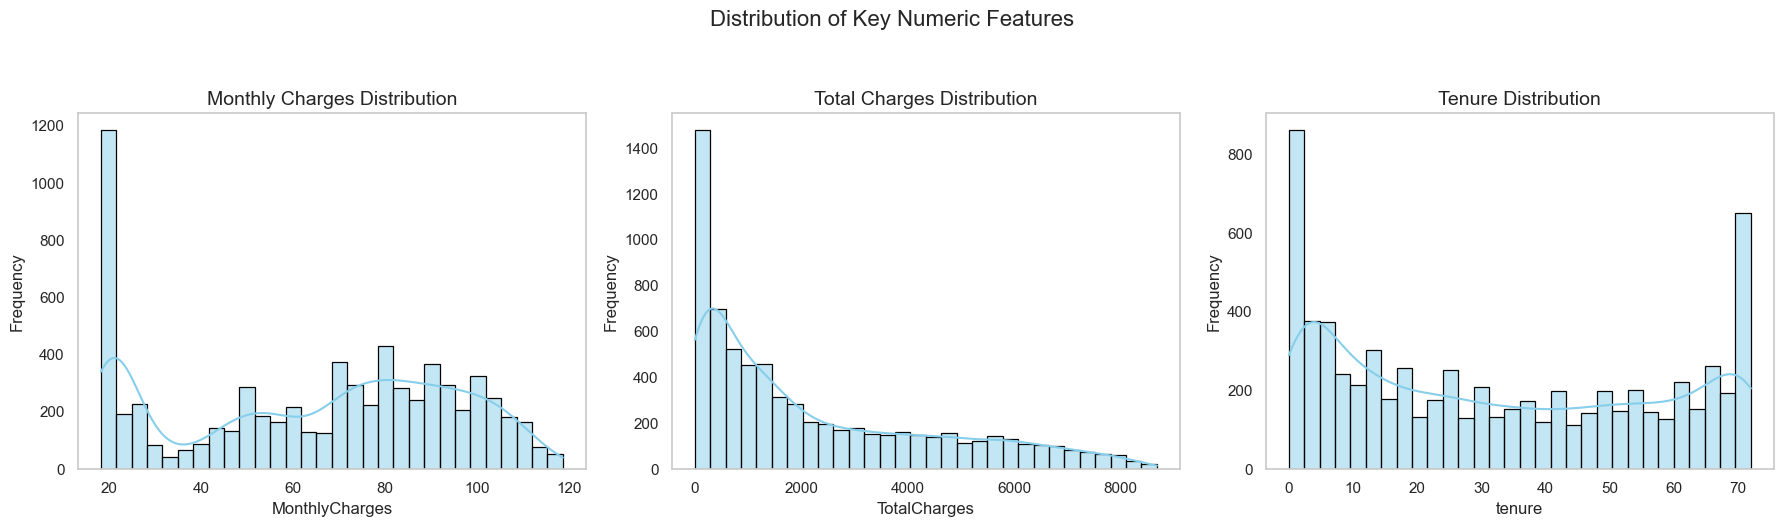

In [10]:
# Set a clean style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
features = ['MonthlyCharges', 'TotalCharges', 'tenure']
titles = ['Monthly Charges Distribution', 'Total Charges Distribution', 'Tenure Distribution']

for i, feature in enumerate(features):
    sns.histplot(data=df, x=feature, kde=True, bins=30, ax=axes[i], color='skyblue', edgecolor='black')
    axes[i].set_title(titles[i], fontsize=14)
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel("Frequency", fontsize=12)
    axes[i].grid(False)

plt.suptitle("Distribution of Key Numeric Features", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

### Check multicollinearity among numeric features

In [11]:
import statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select only the relevant numeric columns
numeric_cols = ['MonthlyCharges', 'TotalCharges', 'tenure']
X_numeric = df[numeric_cols].dropna().astype(float)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = numeric_cols
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]

print("Variance Inflation Factor (VIF) for numeric columns:")
print(vif_data)

Variance Inflation Factor (VIF) for numeric columns:
          feature       VIF
0  MonthlyCharges  3.355660
1    TotalCharges  8.075070
2          tenure  6.332328


### Explore relationship with target (based on correlation matrix)

In [12]:
# Encode binary features
df['gender_encoded'] = df['gender'].apply(lambda x: 0 if x == "Female" else 1)
df['Partner_encoded'] = df['Partner'].apply(lambda x: 0 if x == "No" else 1)
df['Dependents_encoded'] = df['Dependents'].apply(lambda x: 0 if x == "No" else 1)
df['PhoneService_encoded'] = df['PhoneService'].apply(lambda x: 0 if x == "No" else 1)
df['PaperlessBilling_encoded'] = df['PaperlessBilling'].apply(lambda x: 0 if x == "No" else 1)
df['Churn_encoded'] = df['Churn'].apply(lambda x: 0 if x == "No" else 1)

In [13]:
# Important features
df_corr = df[['Churn_encoded', 'gender_encoded', 'PhoneService_encoded', 'SeniorCitizen', 'Partner_encoded', 'MultipleLines_encoded', 
              'InternetService_encoded','StreamingTV_encoded', 'StreamingMovies_encoded',
              'Dependents_encoded', 'tenure', 'OnlineSecurity_encoded', 'OnlineBackup_encoded',
              'DeviceProtection_encoded', 'TechSupport_encoded','Contract_encoded',
              'PaperlessBilling_encoded', 'PaymentMethod_encoded', 'MonthlyCharges', 
              'TotalCharges',]].copy()

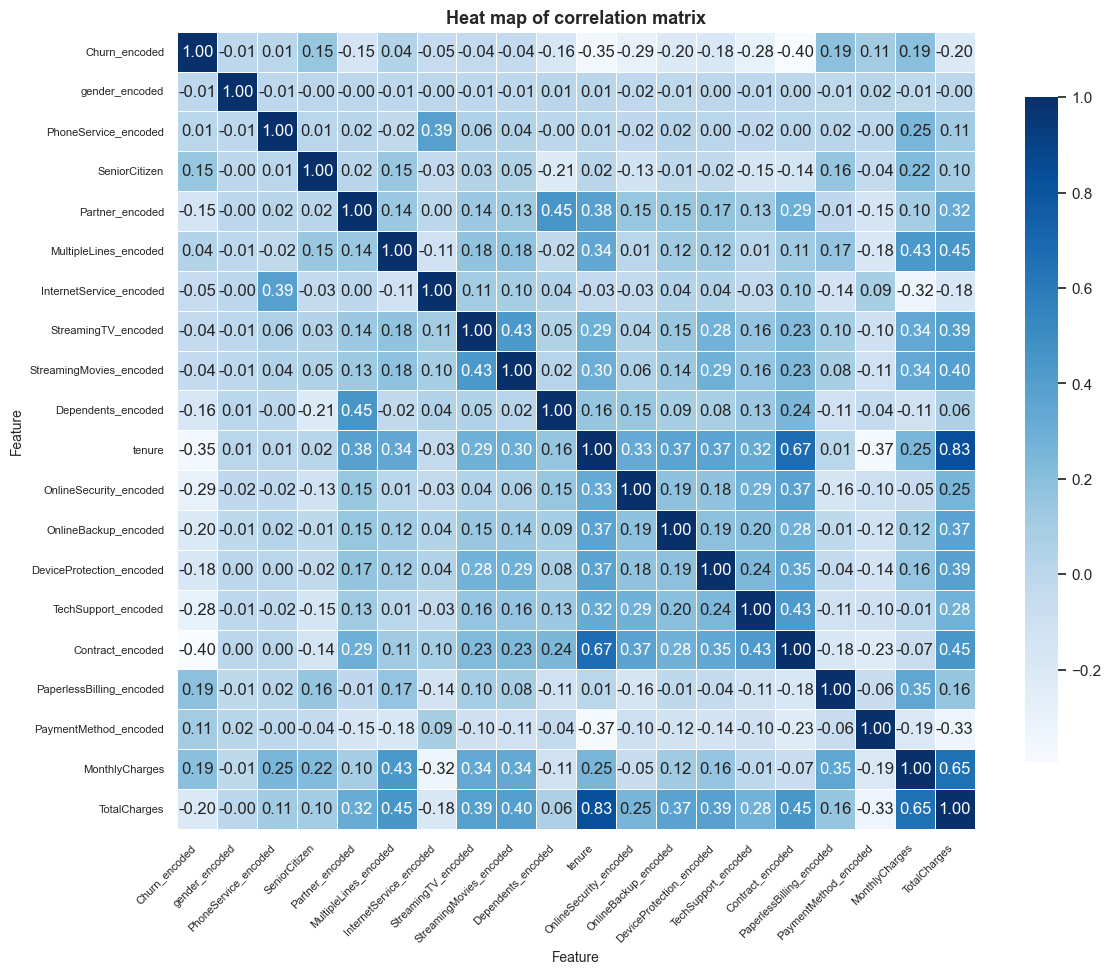

In [14]:
# Reset the index to ensure sequential indexing
df_features = df_corr.reset_index(drop=True)

plt.figure(figsize=(12, 10))
sns.heatmap(df_features.corr(), 
            annot=True,
            cmap="Blues",
            fmt=".2f",
            linewidths=.5,
            square=True,
            cbar_kws={"shrink": .8}
        )

# Add labels, title, and adjust axes params
plt.title("Heat map of correlation matrix", fontsize=13, weight="bold")
plt.xlabel('Feature', fontsize=10)
plt.ylabel('Feature', fontsize=10)
plt.xticks(fontsize=8, rotation=45, ha='right')
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

### Drop less important features from dataset

In [15]:
# Less important features
less_important_features = ['customerID',]
# 'gender_encoded', 'PhoneService_encoded',
# Drop less important features
df.drop(less_important_features, axis=1, inplace=True)

In [16]:
df_base_model = df[['Churn_encoded', 'SeniorCitizen', 'tenure', 'MonthlyCharges', 
                    'TotalCharges', 'MultipleLines_encoded', 'InternetService_encoded',
                    'OnlineSecurity_encoded', 'OnlineBackup_encoded', 'DeviceProtection_encoded', 
                    'TechSupport_encoded', 'StreamingTV_encoded', 'StreamingMovies_encoded', 
                    'Contract_encoded', 'PaymentMethod_encoded', 'Partner_encoded', 
                    'Dependents_encoded', 'PaperlessBilling_encoded', 'gender_encoded', 
                    'PhoneService_encoded',
                ]].copy()

### Create Base Model

#### Logistic regression

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Prepare X and y
X_base_model = df_base_model.drop('Churn_encoded', axis=1)
y_base_model = df_base_model['Churn_encoded']

# Split data
X_train, lr_X_test, y_train,lr_y_test = train_test_split(
    X_base_model, y_base_model, test_size=0.2, random_state=42, stratify=y_base_model
)

# Fit logistic regression
logreg_no_feat_eng_model = LogisticRegression(max_iter=1000, solver='liblinear')
logreg_no_feat_eng_model.fit(X_train, y_train)

# Predict
log_reg_y_pred_1 = logreg_no_feat_eng_model.predict(lr_X_test)
log_reg_y_pred_proba_1 = logreg_no_feat_eng_model.predict_proba(lr_X_test)[:, 1]

# Evaluation
log_reg_1_roc_auc = round(roc_auc_score(lr_y_test, log_reg_y_pred_proba_1), 2)
print(f"ROC AUC : {log_reg_1_roc_auc}")

ROC AUC : 0.84


In [18]:
# View classification report
log_reg_1_cr_dict = classification_report(lr_y_test, log_reg_y_pred_1, output_dict=True)
log_reg_1_cr = classification_report(lr_y_test, log_reg_y_pred_1)
print(log_reg_1_cr)

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.64      0.55      0.59       374

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409



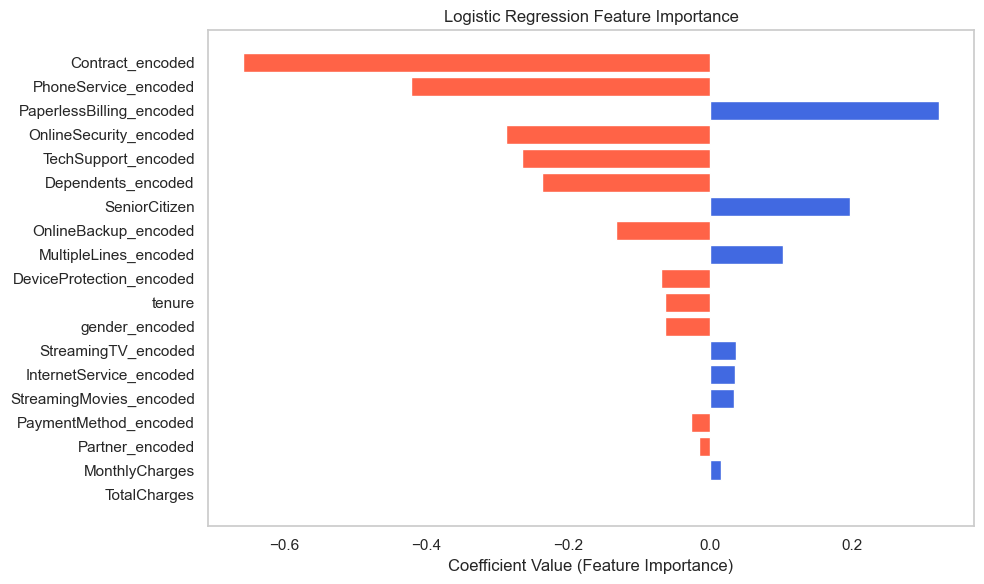

In [19]:
# Feature Importance for Logistic Regression (no feature engineering)
feature_names = X_base_model.columns
coefs = logreg_no_feat_eng_model.coef_[0]

# Sort by absolute value of coefficients
sorted_idx = np.argsort(np.abs(coefs))[::-1]
sorted_features = feature_names[sorted_idx]
sorted_coefs = coefs[sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_coefs, color=np.where(sorted_coefs > 0, "royalblue", "tomato"))
plt.xlabel("Coefficient Value (Feature Importance)")
plt.title("Logistic Regression Feature Importance")
plt.grid(False)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

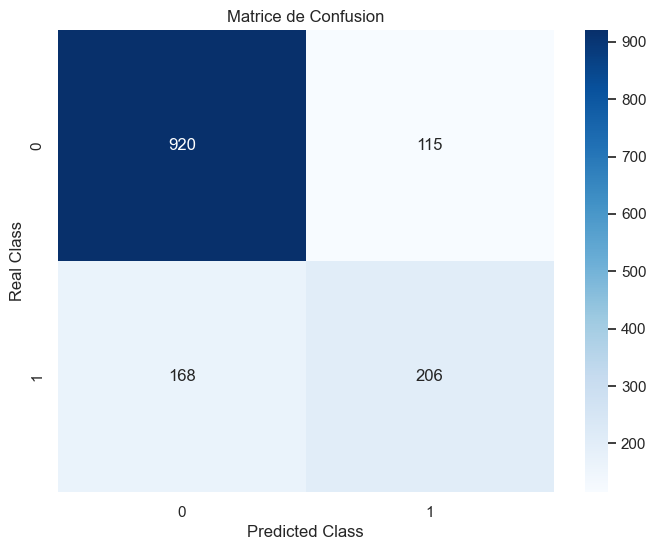

In [20]:
# Plot confusion matrix
log_reg_1_cm = confusion_matrix(lr_y_test, log_reg_y_pred_1)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(log_reg_1_cm, annot=True, fmt='d', cmap='Blues') 
plt.title("Matrice de Confusion")
plt.xlabel("Predicted Class")
plt.ylabel("Real Class")
plt.show()

### Create logistic regression model

#### Prepare new data with engineered features

In [21]:
df_feat_eng = df[['Churn_encoded', 'gender_encoded', 'SeniorCitizen', 'Partner_encoded', 
                    'Dependents_encoded', 'PaperlessBilling_encoded', 'PhoneService_encoded',
                    'MultipleLines', 'InternetService', 'OnlineSecurity',
                    'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
                    'StreamingMovies',  'Contract',  'PaymentMethod','tenure',
                     'MonthlyCharges', 'TotalCharges', 
                ]].copy()

#### Update select feature groups

- Group data by service unavailability

In [22]:
# Group "No internet service" with "No" for TechSupport feature
df_feat_eng['TechSupport'] = df_feat_eng['TechSupport'].replace('No internet service', 'No').map({'No': 0, 'Yes': 1})

# Group "No internet service" with "No" for StreamingMovies feature
df_feat_eng['StreamingMovies'] = df_feat_eng['StreamingMovies'].replace('No internet service', 'No').map({'No': 0, 'Yes': 1})

# Group "No internet service" with "No" for StreamingTV feature
df_feat_eng['StreamingTV'] = df_feat_eng['StreamingTV'].replace('No internet service', 'No').map({'No': 0, 'Yes': 1})

# Group "No internet service" with "No" for DeviceProtection feature
df_feat_eng['DeviceProtection'] = df_feat_eng['DeviceProtection'].replace('No internet service', 'No').map({'No': 0, 'Yes': 1})

# Group "No internet service" with "No" for OnlineBackup feature
df_feat_eng['OnlineBackup'] = df_feat_eng['OnlineBackup'].replace('No internet service', 'No').map({'No': 0, 'Yes': 1})

# Group "No internet service" with "No" for OnlineSecurity feature
df_feat_eng['OnlineSecurity'] = df_feat_eng['OnlineSecurity'].replace('No internet service', 'No').map({'No': 0, 'Yes': 1})

# Group "No internet service" with "No" for MultipleLines feature
df_feat_eng['MultipleLines'] = df_feat_eng['MultipleLines'].replace('No phone service', 'No').map({'No': 0, 'Yes': 1})

# Encode internet service
df_feat_eng['Internet_service_encoded'] = df_feat_eng['InternetService'].apply(lambda x: 0 if x == 'No' else 1)

#### Create interaction features (non-polynomial)

In [23]:
# Contract categorized
df_feat_eng['contract_payment_frequency'] = df_feat_eng['Contract'].map({
    'Month-to-month': 1,
    'One year': 12,
    'Two year': 24
})

df_feat_eng['is_long_term_contract'] = df_feat_eng['contract_payment_frequency'].apply(lambda x: 0 if x < 2 else 1)

# Calculate spend rate
df_feat_eng['avg_monthly_spend'] = np.where(
    df_feat_eng['tenure'] == 0,
    0,
    df_feat_eng['TotalCharges'] / df_feat_eng['tenure']
)

# Create tenure categories
df_feat_eng['tenure_categories'] = pd.cut(df_feat_eng['tenure'], bins=[-1, 18, 36, 54, 72], labels=['New', 'Early', 'Established', 'Loyal'])

# Elderly customers needing support
df_feat_eng['elderly_support_need'] = df_feat_eng['SeniorCitizen'] * df_feat_eng['TechSupport']

# Count of the number of services the customer is subscribed to
df_feat_eng['ServiceCount'] = df_feat_eng[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                         'TechSupport', 'StreamingTV', 'StreamingMovies']].apply(lambda row: sum(row == 1), axis=1)

# Relationship between service and content use.
df_feat_eng['Internet_x_streamingtv'] = df_feat_eng['Internet_service_encoded'] * df_feat_eng['StreamingTV']
df_feat_eng['Internet_x_streamingmovies'] = df_feat_eng['Internet_service_encoded'] * df_feat_eng['StreamingMovies']
df_feat_eng['Internet_x_all_streaming_service'] = df_feat_eng['Internet_service_encoded'] * df_feat_eng['StreamingTV'] * df_feat_eng['StreamingMovies']

# Paperless with PhoneService 
df_feat_eng['Phone_Paperless_Interaction'] = (
    df_feat_eng['PhoneService_encoded'] * df_feat_eng['PaperlessBilling_encoded']
)

# PhoneService with MultipleLines 
df_feat_eng['Phoneservice_x_multiple_lines'] = (
    df_feat_eng['PhoneService_encoded'] * df_feat_eng['MultipleLines']
)

# Contract by Gender
df_feat_eng['gender_contract'] = df_feat_eng['gender_encoded'].astype(str) + '_' + df_feat_eng['Contract'].astype(str)

# Contract by payment method
df_feat_eng['payment_method_contract'] = df_feat_eng['PaymentMethod'].astype(str) + '_' + df_feat_eng['Contract'].astype(str)

# Internet servive and Techsupport
df_feat_eng['internet_x_techsupport'] = df_feat_eng['InternetService'].astype(str) + '_' + df_feat_eng['TechSupport'].astype(str)

#### Drop two features identified

In [24]:
df_feat_eng.drop(columns=['gender_encoded', 'PhoneService_encoded'], axis=1, inplace = True)

#### One-hot encode select features

In [25]:
onehot_encode_list = ['tenure_categories', 'InternetService', 'Contract', 'PaymentMethod',
                      'gender_contract', 'payment_method_contract', 'internet_x_techsupport']

df_one_hot_feat = pd.get_dummies(
    df_feat_eng, 
    columns=onehot_encode_list,
    drop_first=False
).astype('int64')

### Prepare dataframe for modeling

### Turn column names to lowercase

In [26]:
df_one_hot_feat.columns = df_one_hot_feat.columns.str.lower()

### Scale numeric features and add polynomial features

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.pipeline import Pipeline

features_to_normalize = ['monthlycharges', 'totalcharges', 'tenure', 'servicecount', 'avg_monthly_spend', 'contract_payment_frequency']

# Apply polynomial features to numeric columns
pipeline = Pipeline([
('log', FunctionTransformer(np.log1p, feature_names_out='one-to-one')),
('poly', PolynomialFeatures(degree=2, include_bias=False)),
('scale', StandardScaler())
])

# Select the columns to normalize
X_num = df_one_hot_feat[features_to_normalize]

# Apply the pipeline to the numeric features
X_num_transformed = pipeline.fit_transform(X_num)

# Get new column names after polynomial features
poly_feature_names = pipeline.named_steps['poly'].get_feature_names_out(features_to_normalize)

# Create a DataFrame for the transformed features
df_num_transformed = pd.DataFrame(X_num_transformed, columns=poly_feature_names, index=df_one_hot_feat.index)

# df_num_transformed = pd.DataFrame(X_num_transformed, columns=features_to_normalize, index=df_one_hot_feat.index)

# Drop the original numeric columns from df_one_hot_feat
df_rest = df_one_hot_feat.drop(columns=features_to_normalize)

# Concatenate the transformed numeric features with the rest
df_final = pd.concat([df_rest, df_num_transformed], axis=1)

### Re-train base model (logistic regression) on new df with engineered features

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Prepare X and y
X_base_model_feat = df_final.drop(columns=["churn_encoded"], axis=1)
y_base_model_feat = df_final["churn_encoded"]

# Split data
X_train_2, lr_X_test_2, y_train_2, lr_y_test_2 = train_test_split(
    X_base_model_feat, y_base_model_feat, test_size=0.2, random_state=42, stratify=y_base_model_feat
)

# Fit logistic regression
logreg_with_feat_eng_model  = LogisticRegression(max_iter=1000, solver='liblinear')
logreg_with_feat_eng_model.fit(X_train_2, y_train_2)

# Predict
log_reg_y_pred_2 = logreg_with_feat_eng_model.predict(lr_X_test_2)
log_reg_y_pred_proba_2 = logreg_with_feat_eng_model.predict_proba(lr_X_test_2)[:, 1]

# Evaluation
log_reg_2_roc_auc = round(roc_auc_score(lr_y_test_2, log_reg_y_pred_proba_2), 2)
print(f"ROC AUC: {log_reg_2_roc_auc}")

ROC AUC: 0.85


In [30]:
# View classification report
log_reg_2_cr_dict = classification_report(lr_y_test_2, log_reg_y_pred_2, output_dict=True)
log_reg_2_cr = classification_report(lr_y_test_2, log_reg_y_pred_2)
print(log_reg_2_cr)

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.67      0.53      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.80      0.80      0.80      1409



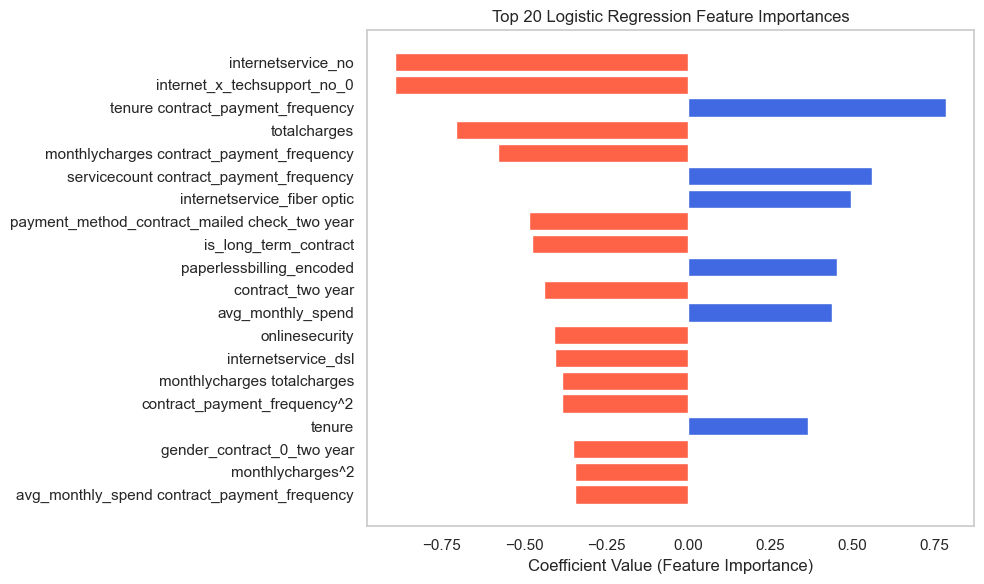

In [31]:
# Feature Importance for Logistic Regression (no feature engineering)
feature_names = X_base_model_feat.columns
coefs = logreg_with_feat_eng_model.coef_[0]

# Sort by absolute value of coefficients
sorted_idx = np.argsort(np.abs(coefs))[::-1]
sorted_features = feature_names[sorted_idx]
sorted_coefs = coefs[sorted_idx]

# Get top 20 features
top_n = 20
top_features = sorted_features[:top_n]
top_coefs = sorted_coefs[:top_n]

plt.figure(figsize=(10, 6))
plt.barh(top_features, top_coefs, color=np.where(top_coefs > 0, "royalblue", "tomato"))
plt.xlabel("Coefficient Value (Feature Importance)")
plt.title(f"Top {top_n} Logistic Regression Feature Importances")
plt.grid(False)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

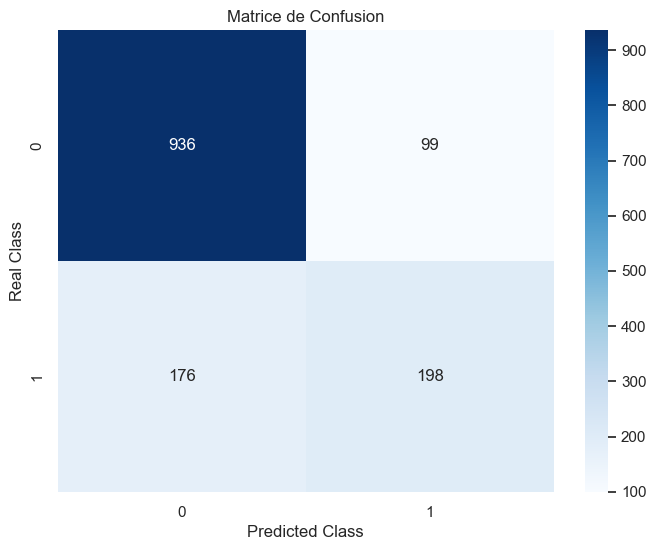

In [33]:
# Plot confusion matrix
log_reg_2_cm = confusion_matrix(lr_y_test_2, log_reg_y_pred_2)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(log_reg_2_cm, annot=True, fmt='d', cmap='Blues') 
plt.title("Matrice de Confusion")
plt.xlabel("Predicted Class")
plt.ylabel("Real Class")
plt.show()

## Tensorflow models

#### Without Feat Engineering

In [34]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

# Séparation train/val/test (80/20 puis 20% de train pour val)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    X_base_model, y_base_model, test_size=0.2, random_state=42, stratify=y_base_model
)

# Compute class weights before training
# Get unique classes
classes_1 = np.unique(y_train_1)
# Compute class weights
class_weights_1 = compute_class_weight(class_weight='balanced', classes=classes_1, y=y_train_1)
# Convert to dict for use in model
class_weight_dict_1 = dict(zip(classes_1, class_weights_1))

# On prend 20% de X_train pour validation
X_train_no_feat, X_val_no_feat, y_train_no_feat, y_val_no_feat = train_test_split(
    X_train_1, y_train_1, test_size=0.2, random_state=42, stratify=y_train_1)

In [250]:
def build_model(input_shape):
    # Network with 2 hidden layers and 64 neurons each 
    # Has an hidden output layer with sigmoid activation for classification
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_shape,)),
        tf.keras.layers.Dense(125, activation='sigmoid'),
        tf.keras.layers.Dense(125, activation='sigmoid'),
        tf.keras.layers.Dense(125, activation='sigmoid'),
        tf.keras.layers.Dense(125, activation='sigmoid'),
        tf.keras.layers.Dense(256, activation='sigmoid'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Définition de la fonction de perte, de l'optimiseur et des métriques
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    model.summary()

    return model

tf_model_1 = build_model(X_train_no_feat.shape[1])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 125)            │         2,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 125)            │        15,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 125)            │        15,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 125)            │        15,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        32,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,263 (321.34 KB)

 Trainable params: 82,263 (321.34 KB)

 Non-trainable params: 0 (0.00 B)

In [251]:
# Train
history_1 = tf_model_1.fit(
    X_train_no_feat, y_train_no_feat,
    validation_data=(X_val_no_feat, y_val_no_feat),
    epochs=60,
    batch_size=256,
    verbose=1,
    class_weight=class_weight_dict_1
)

Epoch 1/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 158ms/step - accuracy: 0.4624 - auc: 0.4994 - loss: 0.7064 - val_accuracy: 0.2653 - val_auc: 0.6708 - val_loss: 0.7540
Epoch 2/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4578 - auc: 0.5366 - loss: 0.6945 - val_accuracy: 0.2653 - val_auc: 0.6872 - val_loss: 0.6976
Epoch 3/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6373 - auc: 0.6256 - loss: 0.6762 - val_accuracy: 0.2653 - val_auc: 0.7288 - val_loss: 0.7448
Epoch 4/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5620 - auc: 0.6760 - loss: 0.6509 - val_accuracy: 0.7400 - val_auc: 0.7561 - val_loss: 0.5671
Epoch 5/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6987 - auc: 0.7353 - loss: 0.6170 - val_accuracy: 0.7178 - val_auc: 0.7772 - val_loss: 0.5696
Epoch 6/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6978 - auc: 0.7796 - loss: 0.5669 - val_accuracy: 0.6948 - val_auc: 0.7948 - val_loss: 0.5524
Epoch 7/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16m

In [252]:
# Evaluation 
test_loss, test_acc, test_auc = tf_model_1.evaluate(X_test_1, y_test_1, verbose=0)
print(f"\nAccuracy on test set : {test_acc:.2f}")


Accuracy on test set : 0.78


In [293]:
y_pred_probs_1 = tf_model_1.predict(X_test_1)

y_probs_1 = y_pred_probs_1.ravel()

y_pred_1 = (y_probs_1 >= 0.27).astype(int)

print("\nClassification Report :")
tf_1_cr_dict = classification_report(y_test_1, y_pred_1, output_dict=True)

tf_1_cr = classification_report(y_test_1, y_pred_1)
print(tf_1_cr)

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

Classification Report :
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.75      0.76      1409



In [303]:
from sklearn.metrics import roc_auc_score

tf_1_roc_auc = roc_auc_score(y_test_1, y_probs_1)
print(f"ROC AUC: {tf_1_roc_auc:.2f}")

ROC AUC: 0.84


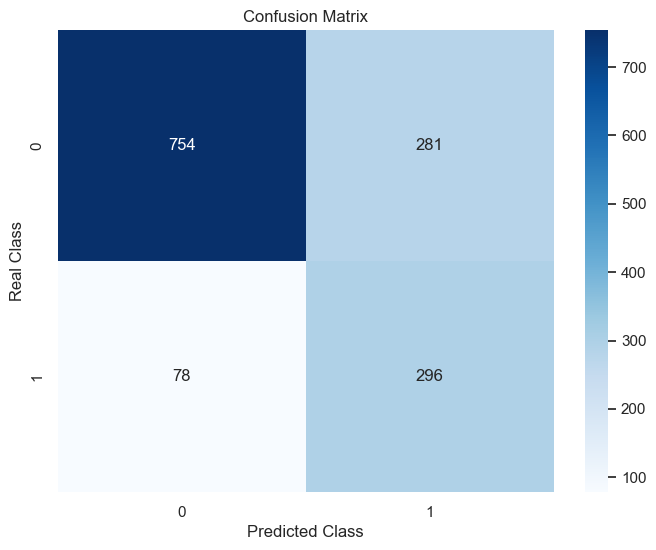

In [305]:
# Plot confusion matrix
tf_cm_1 = confusion_matrix(y_test_1, y_pred_1)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(tf_cm_1, annot=True, fmt='d', cmap='Blues') 
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Real Class")
plt.show()

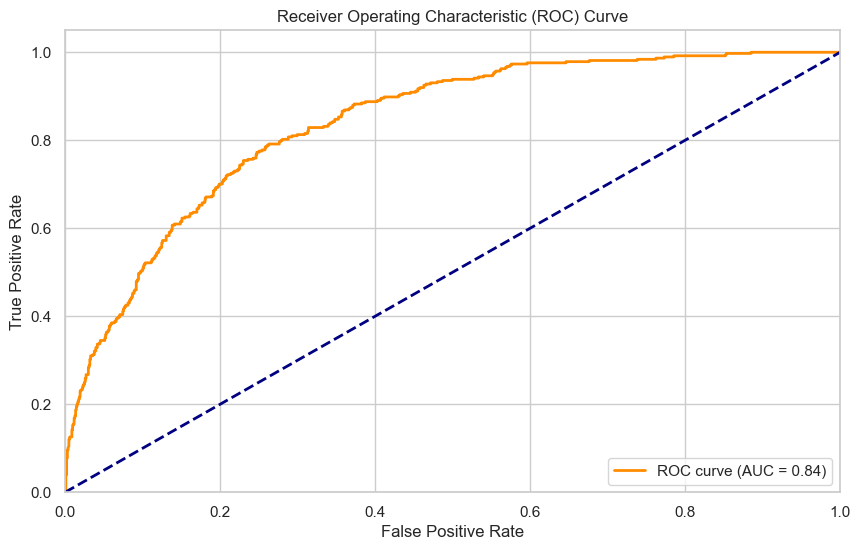

In [306]:
# Plot ROC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test_1, y_pred_probs_1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

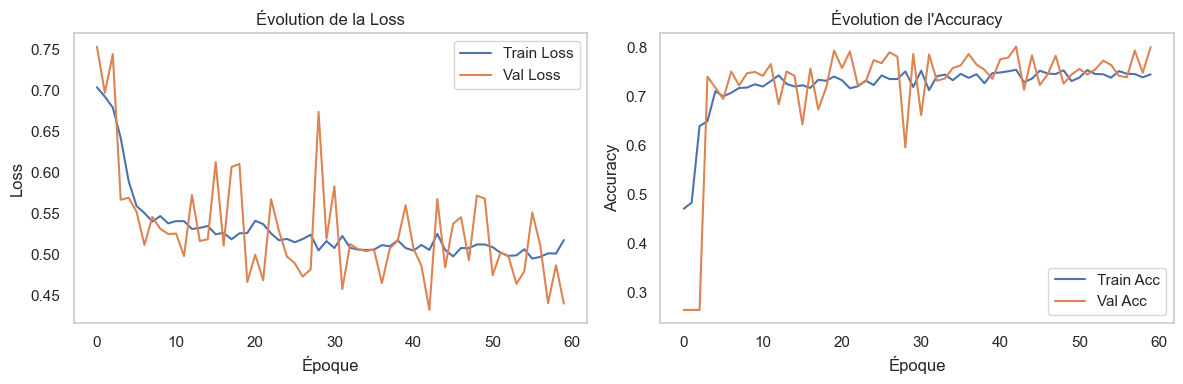

In [307]:
def plot_loss_acc(history, validation=True):
    """
    Trace la loss et l'accuracy du modèle pendant l'entraînement.
    """
    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    if validation and 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Évolution de la Loss')
    plt.xlabel('Époque')
    plt.ylabel('Loss') 
    plt.legend()
    plt.grid()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    if validation and 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Évolution de l'Accuracy")
    plt.xlabel('Époque')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()
    
plot_loss_acc(history_1)

In [ ]:
# tf_model_1.save("tf_model_1.keras")

#### With Feat Engineering

In [54]:
from sklearn.utils.class_weight import compute_class_weight

# Define features (X) and target data (y)
X = df_final.drop(columns=["churn_encoded"], axis=1)
y = df_final["churn_encoded"]

# Séparation train/val/test (80/20 puis 20% de train pour val)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Compute class weights before training
# Get unique classes
classes_2 = np.unique(y_train_2)
# Compute class weights
class_weights_2 = compute_class_weight(class_weight='balanced', classes=classes_2, y=y_train_2)
# Convert to dict for use in model
class_weight_dict_2 = dict(zip(classes_2, class_weights_2))

# On prend 20% de X_train pour validation
X_train_with_feat, X_val_with_feat, y_train_with_feat, y_val_with_feat = train_test_split(
    X_train_2, y_train_2, test_size=0.2, random_state=42, stratify=y_train_2)

In [149]:
def build_model(input_shape):
    # Network with 2 hidden layers and 64 neurons each 
    # Has an hidden output layer with sigmoid activation for classification
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_shape,)),
        tf.keras.layers.Dense(125, activation='sigmoid'),
        tf.keras.layers.Dense(125, activation='sigmoid'),
        tf.keras.layers.Dense(125, activation='sigmoid'),
        tf.keras.layers.Dense(125, activation='sigmoid'),
        tf.keras.layers.Dense(256, activation='sigmoid'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Définition de la fonction de perte, de l'optimiseur et des métriques
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0013256241419324223),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    model.summary()

    return model

tf_model_2 = build_model(X_train_with_feat.shape[1])

Model: "sequential_451"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2352 (Dense)              │ (None, 125)            │        10,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2353 (Dense)              │ (None, 125)            │        15,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2354 (Dense)              │ (None, 125)            │        15,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2355 (Dense)              │ (None, 125)            │        15,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2356 (Dense)              │ (None, 256)            │        32,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2357 (Dense)              │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,263 (352.59 KB)

 Trainable params: 90,263 (352.59 KB)

 Non-trainable params: 0 (0.00 B)

In [216]:
# Train
history_2 = tf_model_2.fit(
    X_train_with_feat, y_train_with_feat,
    validation_data=(X_val_with_feat, y_val_with_feat),
    epochs=60,
    batch_size=256,
    verbose=1,
    class_weight=class_weight_dict_2
)

Epoch 1/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - accuracy: 0.4605 - auc: 0.4833 - loss: 0.7221 - val_accuracy: 0.2653 - val_auc: 0.5860 - val_loss: 0.7281
Epoch 2/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5185 - auc: 0.5406 - loss: 0.6942 - val_accuracy: 0.7347 - val_auc: 0.8115 - val_loss: 0.6441
Epoch 3/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6861 - auc: 0.7300 - loss: 0.6667 - val_accuracy: 0.6948 - val_auc: 0.8378 - val_loss: 0.5672
Epoch 4/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7150 - auc: 0.8182 - loss: 0.5365 - val_accuracy: 0.7560 - val_auc: 0.8453 - val_loss: 0.5160
Epoch 5/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7612 - auc: 0.8410 - loss: 0.5009 - val_accuracy: 0.7595 - val_auc: 0.8477 - val_loss: 0.5155
Epoch 6/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7569 - auc: 0.8411 - loss: 0.4974 - val_accuracy: 0.7657 - val_auc: 0.8494 - val_loss: 0.4799
Epoch 7/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms

In [217]:
# Evaluation 
test_loss, test_acc, test_auc = tf_model_2.evaluate(X_test_2, y_test_2, verbose=0)
print(f"\nAccuracy on test set : {test_acc:.2f}")


Accuracy on test set : 0.73


In [300]:
y_pred_probs_2 = tf_model_2.predict(X_test_2)

y_probs_2 = y_pred_probs_2.ravel()

y_pred_2 = (y_probs_2 >= 0.54).astype(int)
print("\nClassification Report :")
tf_2_cr_dict = classification_report(y_test_2, y_pred_2, output_dict=True)

tf_2_cr  = classification_report(y_test_2, y_pred_2)
print(tf_2_cr)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Classification Report :
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1035
           1       0.51      0.80      0.63       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.81      0.75      0.76      1409



In [301]:
from sklearn.metrics import roc_auc_score

tf_2_roc_auc = roc_auc_score(y_test_2, y_probs_2)
print(f"ROC AUC: {tf_2_roc_auc:.2f}")

ROC AUC: 0.85


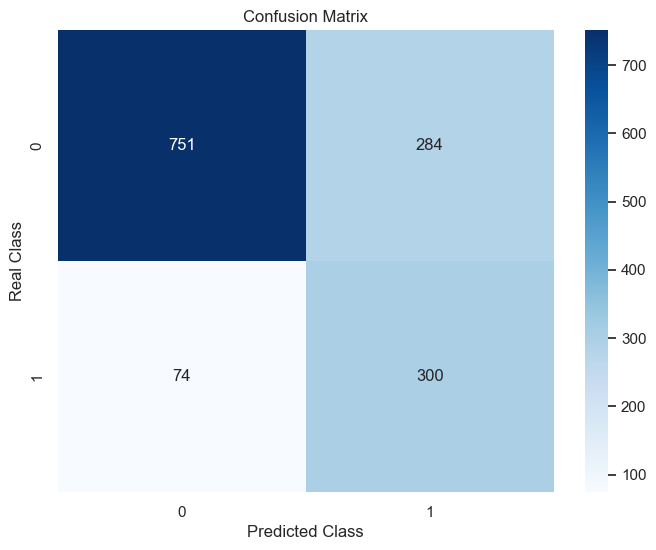

In [304]:
# Plot confusion matrix
tf_cm_2 = confusion_matrix(y_test_2, y_pred_2)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(tf_cm_2, annot=True, fmt='d', cmap='Blues') 
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Real Class")
plt.show()

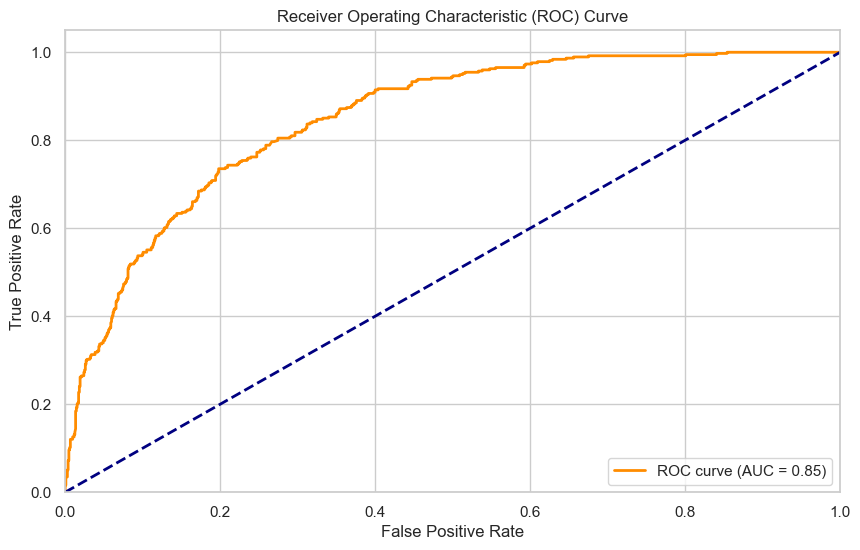

In [248]:
# Plot ROC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test_2, y_pred_probs_2)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

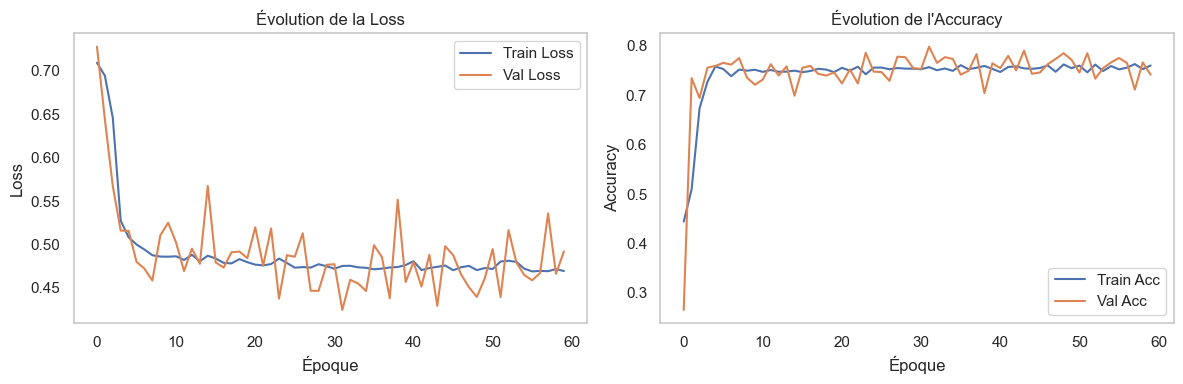

In [249]:
def plot_loss_acc(history, validation=True):
    """
    Trace la loss et l'accuracy du modèle pendant l'entraînement.
    """
    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    if validation and 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Évolution de la Loss')
    plt.xlabel('Époque')
    plt.ylabel('Loss') 
    plt.legend()
    plt.grid()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    if validation and 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Évolution de l'Accuracy")
    plt.xlabel('Époque')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()
    
plot_loss_acc(history_2)

## Model Fine-tuning

### Clone models

In [345]:
import gc

# Reset session
tf.keras.backend.clear_session()

# Clone previous model
from tensorflow.keras.models import clone_model

tf_model_1 = build_model(X_train_no_feat.shape[1])
tf_model_2 = build_model(X_train_with_feat.shape[1])

# copies architecture
tf_model_3 = clone_model(tf_model_1)   
tf_model_4 = clone_model(tf_model_2)

# copies weights 
tf_model_3.set_weights(tf_model_1.get_weights())  
tf_model_4.set_weights(tf_model_2.get_weights())  

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 125)            │         2,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 125)            │        15,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 125)            │        15,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 125)            │        15,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        32,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,263 (321.34 KB)

 Trainable params: 82,263 (321.34 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 125)            │        10,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 125)            │        15,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 125)            │        15,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 125)            │        15,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        32,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,263 (352.59 KB)

 Trainable params: 90,263 (352.59 KB)

 Non-trainable params: 0 (0.00 B)

### TensorBoard

In [ ]:
%load_ext tensorboard

### Early stopping and ModelCheckpoint

In [ ]:
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import datetime
from tensorflow.keras.callbacks import TensorBoard

def get_callbacks(model_name, monitor='val_accuracy'):
    # Checkpoint
    checkpoint_dir = f"checkpoints/{model_name}"
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, "best_model.keras")

    # TensorBoard log directory
    log_dir = os.path.join("logs", "fit", model_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_cb = TensorBoard(
        log_dir=log_dir,
        histogram_freq=1,
        write_graph=True,
        write_images=True
    )

    # Early stopping
    early_stop = EarlyStopping(
        monitor='val_auc',
        patience=10,
        restore_best_weights=True
    )

    model_ckpt = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor=monitor,
        save_best_only=True,
        verbose=1
    )

    return [early_stop, model_ckpt, tensorboard_cb], checkpoint_path


### Callbacks

In [376]:
# Callbacks and paths
callbacks_3, checkpoint_path_3 = get_callbacks("tf_model_3")
callbacks_4, checkpoint_path_4 = get_callbacks("tf_model_4")

# Train model 3
history_3 = tf_model_3.fit(
    X_train_no_feat, y_train_no_feat,
    validation_split=0.2,
    epochs=60,
    batch_size=256,
    callbacks=callbacks_3,
    verbose=1
)

# Train model 4
history_4 = tf_model_4.fit(
    X_train_with_feat, y_train_with_feat,
    validation_split=0.2,
    epochs=60,
    batch_size=256,
    callbacks=callbacks_4,
    verbose=1
)


Epoch 1/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8093 - auc: 0.8380 - loss: 0.4175
Epoch 1: val_accuracy improved from -inf to 0.78271, saving model to checkpoints/tf_model_3/best_model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.8086 - auc: 0.8378 - loss: 0.4180 - val_accuracy: 0.7827 - val_auc: 0.8321 - val_loss: 0.4513
Epoch 2/60
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7956 - auc: 0.8420 - loss: 0.4226
Epoch 2: val_accuracy improved from 0.78271 to 0.79712, saving model to checkpoints/tf_model_3/best_model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7957 - auc: 0.8384 - loss: 0.4250 - val_accuracy: 0.7971 - val_auc: 0.8240 - val_loss: 0.4539
Epoch 3/60
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8024 - auc: 0.8264 - loss: 0.4393 
Epoch 3: val_accuracy improved from 0.79712 to 0.79823, saving model to checkpoints/tf_model_3/best_model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7991 - auc: 0.8224 -

### Evaluate models

In [ ]:
from tensorflow.keras.models import load_model

def evaluate_model(checkpoint_path, X_test, y_test, threshold):
    model = load_model(checkpoint_path)

    test_loss, test_acc, test_auc = model.evaluate(X_test, y_test, verbose=0)
    print(f"\n✅ Test Accuracy: {test_acc:.2f}")
    print(f"\n✅ Test AUC: {test_auc:.2f}")

    probs = model.predict(X_test).ravel()
    y_pred = (probs >= threshold).astype(int)

    # Save classification report as dict
    cr_dict = classification_report(y_test, y_pred, output_dict=True)
    print("\n📊 Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return cr_dict, probs


✅ Test Accuracy: 0.79

✅ Test AUC: 0.83
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1035
           1       0.51      0.80      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.74      0.76      1409



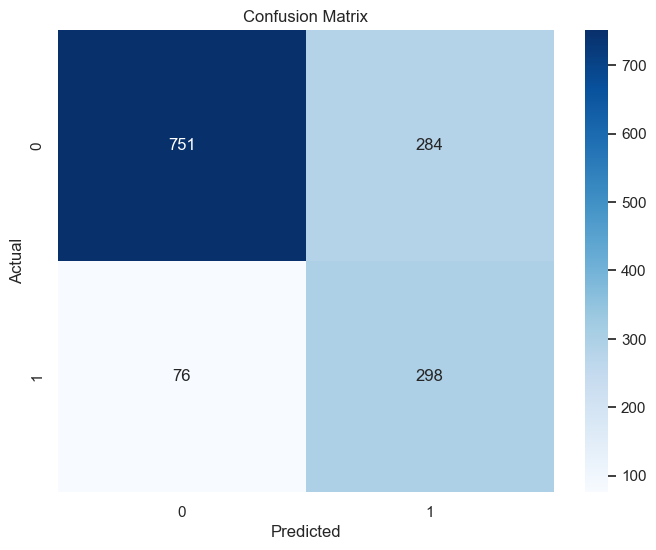


✅ Test Accuracy: 0.79

✅ Test AUC: 0.85
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1035
           1       0.51      0.81      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409



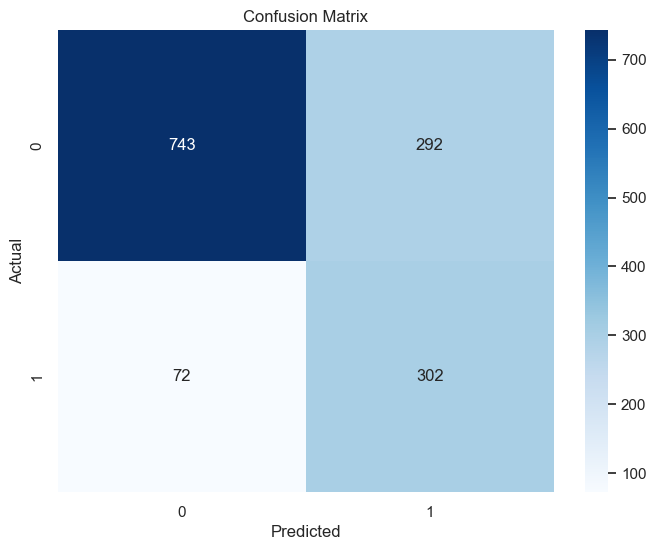

In [407]:
# Evaluate Model 3
tf_3_cr_dict, y_probs_3 = evaluate_model(checkpoint_path_3, X_test_1, y_test_1, threshold=0.135)
tf_3_roc_auc = round(roc_auc_score(y_test_1, y_probs_3), 2)

# Evaluate Model 4
tf_4_cr_dict, y_probs_4 = evaluate_model(checkpoint_path_4, X_test_2, y_test_2, threshold=0.187)
tf_4_roc_auc = round(roc_auc_score(y_test_2, y_probs_4), 2)

In [410]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 36191), started 3 days, 12:24:14 ago. (Use '!kill 36191' to kill it.)

## Optuna evaluation

- Define optuna's objective function

In [411]:
import optuna
from tensorflow import keras

def optuna_objective(trial, X_train, y_train, X_val, y_val, class_weight_dict):
    n_units = trial.suggest_int('n_units', 64, 256, step=16)
    n_layers = trial.suggest_int('n_layers', 2, 14)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 2e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256])
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.3, step=0.05)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop', 'Adagrad'])
    epochs = trial.suggest_int('epochs', 50, 80)

    # Optimizer
    if optimizer_name == 'Adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == 'SGD':
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    elif optimizer_name == 'RMSprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_name == 'Adagrad':
        optimizer = keras.optimizers.Adagrad(learning_rate=learning_rate)

    # Build model
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(X_train.shape[1],)))
    for _ in range(n_layers):
        model.add(keras.layers.Dense(n_units, activation=activation))
        model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Recall(name='recall')]
    )

    optuna_history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        class_weight=class_weight_dict,
        callbacks=[
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=7,
                restore_best_weights=True
            )
        ]
    )

    val_auc = max(optuna_history.history['val_auc'])
    return val_auc

- Run study for the models

In [412]:
import optuna

# For dataset 1 (no feature engineering)
study_1 = optuna.create_study(direction='maximize')
study_1.optimize(lambda trial: optuna_objective(
    trial, X_train_no_feat, y_train_no_feat, X_val_no_feat, y_val_no_feat, class_weight_dict_1
), n_trials=20)

# For dataset 2 (with feature engineering)
study_2 = optuna.create_study(direction='maximize')
study_2.optimize(lambda trial: optuna_objective(
    trial, X_train_with_feat, y_train_with_feat, X_val_with_feat, y_val_with_feat, class_weight_dict_2
), n_trials=20)

[I 2025-05-25 22:47:24,498] A new study created in memory with name: no-name-0b2812fe-66fe-42b5-9f00-faf7e67adfd3
[I 2025-05-25 22:47:54,786] Trial 0 finished with value: 0.6506490707397461 and parameters: {'n_units': 128, 'n_layers': 6, 'learning_rate': 0.001724941023106716, 'batch_size': 128, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'SGD', 'epochs': 60}. Best is trial 0 with value: 0.6506490707397461.
[I 2025-05-25 22:48:26,550] Trial 1 finished with value: 0.5 and parameters: {'n_units': 64, 'n_layers': 6, 'learning_rate': 0.0012444720708940664, 'batch_size': 128, 'dropout_rate': 0.15000000000000002, 'activation': 'sigmoid', 'optimizer': 'SGD', 'epochs': 52}. Best is trial 0 with value: 0.6506490707397461.
[I 2025-05-25 22:49:27,793] Trial 2 finished with value: 0.5 and parameters: {'n_units': 80, 'n_layers': 11, 'learning_rate': 0.017418719635763066, 'batch_size': 256, 'dropout_rate': 0.05, 'activation': 'tanh', 'optimizer': 'RMSprop', 'epochs': 63}. Best is trial 0 

- Retrain best on best params

In [413]:
def retrain_best_model(best_params, X_train, y_train, X_val, y_val, class_weight_dict):
    # Optimizer
    if best_params['optimizer'] == 'Adam':
        optimizer = keras.optimizers.Adam(learning_rate=best_params['learning_rate'])
    elif best_params['optimizer'] == 'SGD':
        optimizer = keras.optimizers.SGD(learning_rate=best_params['learning_rate'], momentum=0.9)
    elif best_params['optimizer'] == 'RMSprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=best_params['learning_rate'])
    elif best_params['optimizer'] == 'Adagrad':
        optimizer = keras.optimizers.Adagrad(learning_rate=best_params['learning_rate'])

    # Build model
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(X_train.shape[1],)))
    for _ in range(best_params['n_layers']):
        model.add(keras.layers.Dense(best_params['n_units'], activation=best_params['activation']))
        model.add(keras.layers.Dropout(best_params['dropout_rate']))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Recall(name='recall')]
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        verbose=1,
        class_weight=class_weight_dict
    )
    return model, history

- Evaluate models

In [416]:
# Retrain for dataset 1
best_params_5 = study_1.best_trial.params
model_5, history_5 = retrain_best_model(
    best_params_5, X_train_no_feat, y_train_no_feat, X_val_no_feat, y_val_no_feat, class_weight_dict_1
)

# Retrain for dataset 2
best_params_6 = study_2.best_trial.params
model_6, history_6 = retrain_best_model(
    best_params_6, X_train_with_feat, y_train_with_feat, X_val_with_feat, y_val_with_feat, class_weight_dict_2
)

Epoch 1/79
18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 408ms/step - accuracy: 0.5597 - auc: 0.5845 - loss: 0.6916 - recall: 0.5529 - val_accuracy: 0.7551 - val_auc: 0.7599 - val_loss: 0.5517 - val_recall: 0.4314
Epoch 2/79
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7078 - auc: 0.7151 - loss: 0.6264 - recall: 0.5669 - val_accuracy: 0.7516 - val_auc: 0.7863 - val_loss: 0.5132 - val_recall: 0.5619
Epoch 3/79
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6793 - auc: 0.7383 - loss: 0.6030 - recall: 0.6437 - val_accuracy: 0.7436 - val_auc: 0.7908 - val_loss: 0.5261 - val_recall: 0.6455
Epoch 4/79
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7277 - auc: 0.7749 - loss: 0.5736 - recall: 0.6814 - val_accuracy: 0.7578 - val_auc: 0.8083 - val_loss: 0.5243 - val_recall: 0.6455
Epoch 5/79
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7203 - auc: 0.7693 - loss: 0.5689 - recall: 0.6793 - val_accuracy: 0.7303 - val_auc: 0.8081 - val_loss: 0.5495 - val_recall: 0.7391
Epoch 6/79
18

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1035
           1       0.53      0.76      0.62       374

    accuracy                           0.76      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.76      0.77      1409

ROC AUC: 0.84


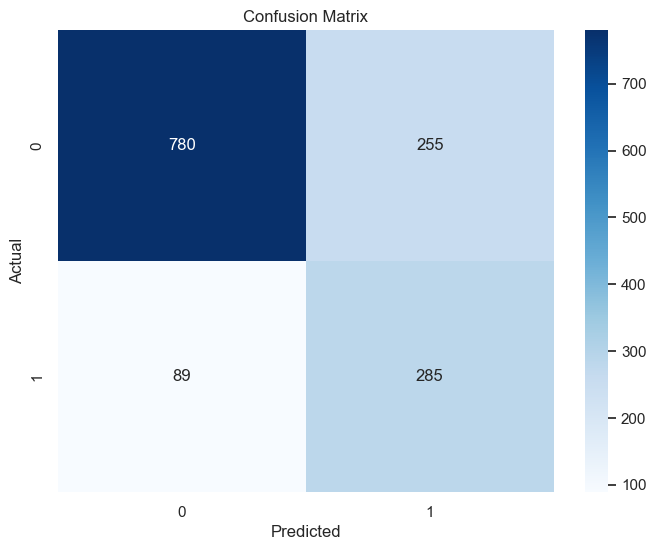

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

           0       0.86      0.75      0.80      1035
           1       0.49      0.67      0.57       374

    accuracy                           0.73      1409
   macro avg       0.68      0.71      0.68      1409
weighted avg       0.76      0.73      0.74      1409

ROC AUC: 0.81


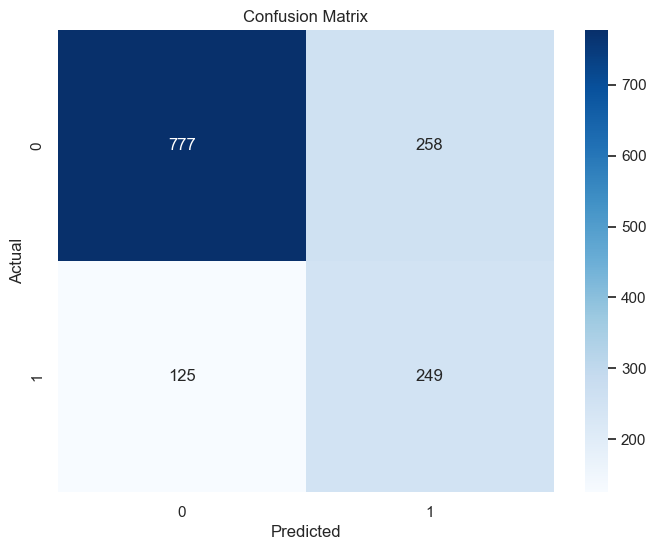

In [444]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

def evaluate_optuna_model(model, X_test, y_test, threshold=0.5):
    """
    Evaluate a trained Keras model (from Optuna) on test data.
    Prints classification report and confusion matrix.
    Returns classification report as dict, ROC AUC, and predicted probabilities.
    """
    # Predict probabilities
    probs = model.predict(X_test).ravel()
    # Predict classes based on threshold
    y_pred = (probs >= threshold).astype(int)
    
    # Classification report
    cr_dict = classification_report(y_test, y_pred, output_dict=True)
    cr_str = classification_report(y_test, y_pred)
    print(cr_str)
    
    # ROC AUC
    roc_auc = roc_auc_score(y_test, probs)
    print(f"ROC AUC: {roc_auc:.2f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    return cr_dict, roc_auc, probs

# Evaluate Optuna model 1 (no feat eng)
optuna_1_cr_dict, optuna_1_roc_auc, optuna_1_probs = evaluate_optuna_model(
    model_5, X_test_1, y_test_1, threshold=0.5
)

# Evaluate Optuna model 2 (with feat eng)
optuna_2_cr_dict, optuna_2_roc_auc, optuna_2_probs = evaluate_optuna_model(
    model_6, X_test_2, y_test_2, threshold=0.52
)

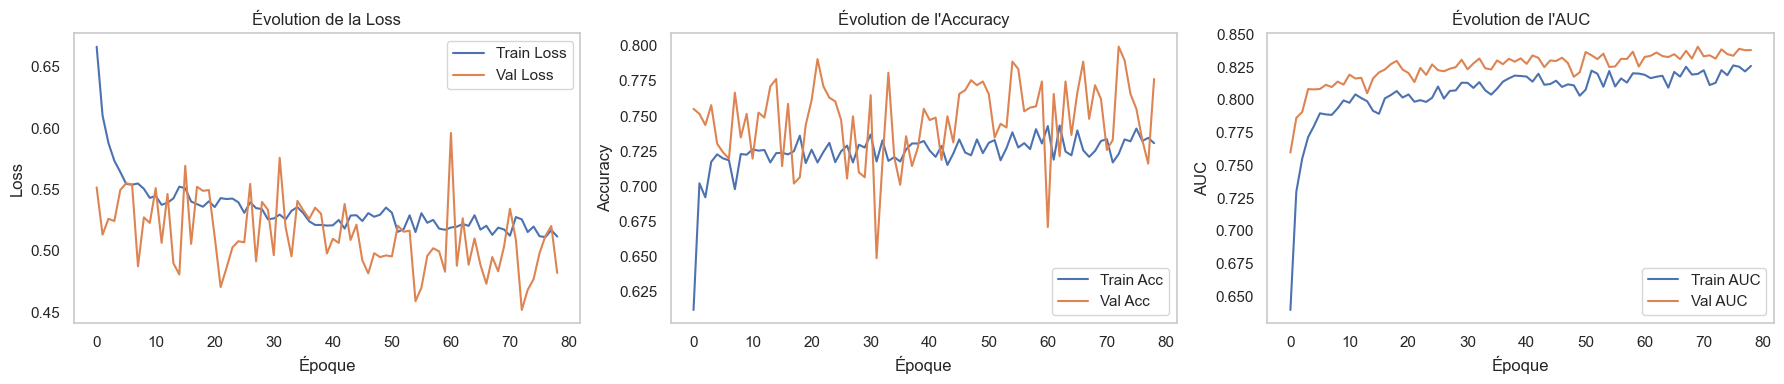

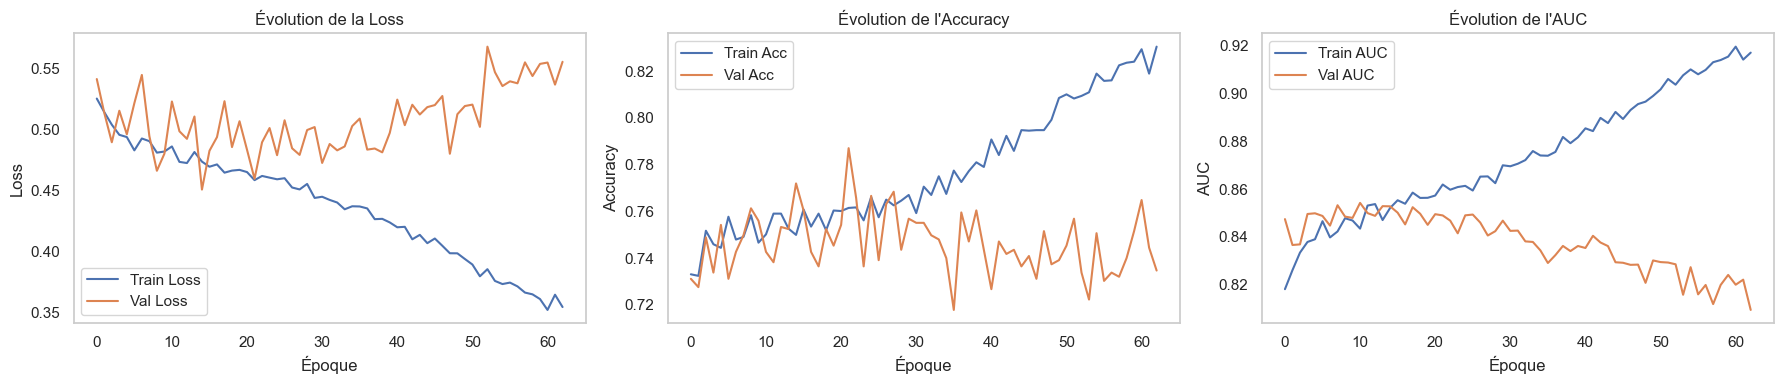

In [443]:
def plot_loss_acc_auc(history, validation=True):
    """
    Plot the evolution of loss, accuracy, and AUC during training.
    """
    plt.figure(figsize=(18, 4))

    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    if validation and 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Évolution de la Loss')
    plt.xlabel('Époque')
    plt.ylabel('Loss') 
    plt.legend()
    plt.grid()

    # Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    if validation and 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Évolution de l'Accuracy")
    plt.xlabel('Époque')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # AUC
    plt.subplot(1, 3, 3)
    plt.plot(history.history['auc'], label='Train AUC')
    if validation and 'val_auc' in history.history:
        plt.plot(history.history['val_auc'], label='Val AUC')
    plt.title("Évolution de l'AUC")
    plt.xlabel('Époque')
    plt.ylabel('AUC')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

plot_loss_acc_auc(history_5)
plot_loss_acc_auc(history_6)

### Compare model results

In [460]:
# Logistic Regression Model 1
recall_0_logreg_1 = round(float(log_reg_1_cr_dict["1"]["recall"]), 2) # type: ignore
f1_logreg_1 = round(float(log_reg_1_cr_dict["1"]["f1-score"]), 2) # type: ignore
roc_auc_logreg_1 = round(float(log_reg_1_roc_auc), 2)
acc_logreg_1 = round(float(log_reg_1_cr_dict["weighted avg"]["f1-score"]), 2) # type: ignore

# Logistic Regression Model 2
recall_0_logreg_2 = round(float(log_reg_2_cr_dict["1"]["recall"]), 2) # type: ignore
f1_logreg_2 = round(float(log_reg_2_cr_dict["1"]["f1-score"]), 2) # type: ignore
roc_auc_logreg_2 = round(float(log_reg_2_roc_auc), 2)
acc_logreg_2 = round(float(log_reg_2_cr_dict["weighted avg"]["f1-score"]), 2) # type: ignore

# Tensorflow Model 1
recall_0_tf_1 = round(float(tf_1_cr_dict["1"]["recall"]), 2) # type: ignore
f1_tf_1 = round(float(tf_1_cr_dict["1"]["f1-score"]), 2) # type: ignore
roc_auc_tf_1 = round(float(tf_1_roc_auc), 2)
acc_tf_1 = round(float(tf_1_cr_dict["weighted avg"]["f1-score"]), 2) # type: ignore

# Tensorflow Model 2
recall_0_tf_2 = round(float(tf_2_cr_dict["1"]["recall"]), 2) # type: ignore
f1_tf_2 = round(float(tf_2_cr_dict["1"]["f1-score"]), 2) # type: ignore
roc_auc_tf_2 = round(float(tf_2_roc_auc), 2)
acc_tf_2 = round(float(tf_2_cr_dict["weighted avg"]["f1-score"]), 2) # type: ignore

# Tensorflow Model 3 (Tf Model 1 Fine-tuned)
recall_0_tf_3 = round(float(tf_3_cr_dict["1"]["recall"]), 2) # type: ignore
f1_tf_3 = round(float(tf_3_cr_dict["1"]["f1-score"]), 2) # type: ignore
roc_auc_tf_3 = round(float(tf_3_roc_auc), 2)
acc_tf_3 = round(float(tf_3_cr_dict["weighted avg"]["f1-score"]), 2) # type: ignore

# Tensorflow Model 4 (Tf Model 2 Fine-tuned)
recall_0_tf_4 = round(float(tf_4_cr_dict["1"]["recall"]), 2) # type: ignore
f1_tf_4 = round(float(tf_4_cr_dict["1"]["f1-score"]), 2) # type: ignore
roc_auc_tf_4 = round(float(tf_4_roc_auc), 2)
acc_tf_4 = round(float(tf_4_cr_dict["weighted avg"]["f1-score"]), 2) # type: ignore

# Optuna Model 1 (no feat eng)
recall_0_optuna_1 = round(float(optuna_1_cr_dict["1"]["recall"]), 2) # type: ignore
f1_optuna_1 = round(float(optuna_1_cr_dict["1"]["f1-score"]), 2) # type: ignore
roc_auc_optuna_1 = round(float(optuna_1_roc_auc), 2)
acc_optuna_1 = round(float(optuna_1_cr_dict["weighted avg"]["f1-score"]), 2) # type: ignore

# Optuna Model 2 (with feat eng)
recall_0_optuna_2 = round(float(optuna_2_cr_dict["1"]["recall"]), 2) # type: ignore
f1_optuna_2 = round(float(optuna_2_cr_dict["1"]["f1-score"]), 2) # type: ignore
roc_auc_optuna_2 = round(float(optuna_2_roc_auc), 2)
acc_optuna_2 = round(float(optuna_2_cr_dict["weighted avg"]["f1-score"]), 2) # type: ignore


# Build results list
results = [
    {
        "Model": "Logistic Regression (no feat eng)",
        "Recall (class 1)": recall_0_logreg_1,
        "F1-score (churn)": f1_logreg_1,
        "ROC-AUC": roc_auc_logreg_1,
        "Weighted avg": acc_logreg_1
    },
    {
        "Model": "Logistic Regression (with feat eng)",
        "Recall (class 1)": recall_0_logreg_2,
        "F1-score (churn)": f1_logreg_2,
        "ROC-AUC": roc_auc_logreg_2,
        "Weighted avg": acc_logreg_2
    },
    {
        "Model": "TensorFlow Model (no feat eng)",
        "Recall (class 1)": recall_0_tf_1,
        "F1-score (churn)": f1_tf_1,
        "ROC-AUC": roc_auc_tf_1,
        "Weighted avg": acc_tf_1
    },
    {
        "Model": "TensorFlow Model (with feat eng)",
        "Recall (class 1)": recall_0_tf_2,
        "F1-score (churn)": f1_tf_2,
        "ROC-AUC": roc_auc_tf_2,
        "Weighted avg": acc_tf_2
    },
    {
        "Model": "TensorFlow Model (Tf Model 1 Fine-tuned)",
        "Recall (class 1)": recall_0_tf_3,
        "F1-score (churn)": f1_tf_3,
        "ROC-AUC": roc_auc_tf_3,
        "Weighted avg": acc_tf_3
    },
    {
        "Model": "TensorFlow Model (Tf Model 2 Fine-tuned)",
        "Recall (class 1)": recall_0_tf_4,
        "F1-score (churn)": f1_tf_4,
        "ROC-AUC": roc_auc_tf_4,
        "Weighted avg": acc_tf_4
    },
    {
        "Model": "Optuna Model (no feat eng)",
        "Recall (class 1)": recall_0_optuna_1,
        "F1-score (churn)": f1_optuna_1,
        "ROC-AUC": roc_auc_optuna_1,
        "Weighted avg": acc_optuna_1
    },
    {
        "Model": "Optuna Model (with feat eng)",
        "Recall (class 1)": recall_0_optuna_2,
        "F1-score (churn)": f1_optuna_2,
        "ROC-AUC": roc_auc_optuna_2,
        "Weighted avg": acc_optuna_2
    },
]

results_df = pd.DataFrame(results)

- Visualize as table

In [465]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML

# Copy results_df to avoid modifying the original
results_table = results_df.copy()

# For each metric, find the max value and mark it with a trophy emoji
for metric in metrics:
    max_val = results_table[metric].max()
    results_table[metric] = results_table[metric].apply(
        lambda x: f"{x:.2f} 🏆" if np.isclose(x, max_val) else f"{x:.2f}"
    )

# Display as a styled table

display(HTML(results_table.to_html(escape=False, index=False)))


Model,Recall (class 1),F1-score (churn),ROC-AUC,Weighted avg
Logistic Regression (no feat eng),0.55,0.59,0.84,0.79
Logistic Regression (with feat eng),0.53,0.59,0.85 🏆,0.80 🏆
TensorFlow Model (no feat eng),0.79,0.62,0.84,0.76
TensorFlow Model (with feat eng),0.80,0.63 🏆,0.85 🏆,0.76
TensorFlow Model (Tf Model 1 Fine-tuned),0.80,0.62,0.83,0.76
TensorFlow Model (Tf Model 2 Fine-tuned),0.81 🏆,0.62,0.85 🏆,0.76
Optuna Model (no feat eng),0.76,0.62,0.84,0.77
Optuna Model (with feat eng),0.67,0.57,0.81,0.74


- Visualize as plot

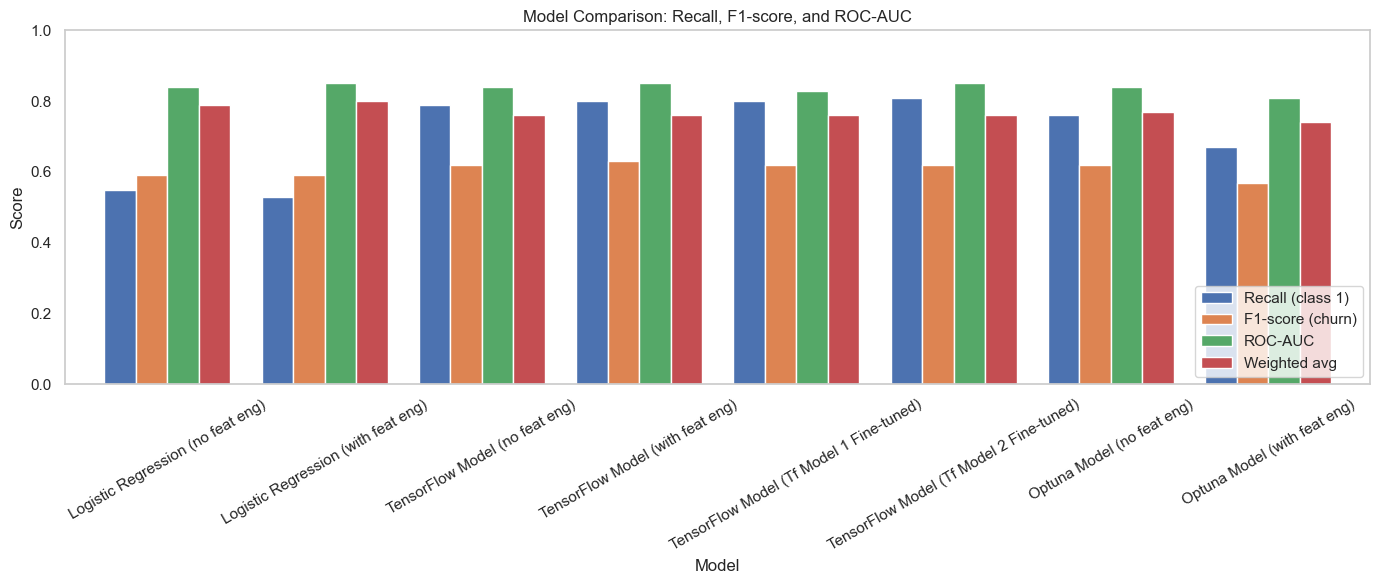

In [464]:
# Bar plot to compare Recall, F1-score, and ROC-AUC for each model
metrics = ["Recall (class 1)", "F1-score (churn)", "ROC-AUC", "Weighted avg"]
results_df.plot(
    x="Model",
    y=metrics,
    kind="bar",
    figsize=(14, 6),
    rot=30,
    width=0.8
)
plt.title("Model Comparison: Recall, F1-score, and ROC-AUC")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(visible=False)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [ ]:
import gc

# tf.keras.backend.clear_session()
# gc.collect()